# Исследование свойств решения уравнений колмогорова

In [1]:
import numpy as np
import ___kolmogorov_models as kolm_mod

from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

from itertools import repeat
from SALib.sample import latin       # pip install SALib
from joblib import Parallel, delayed # pip install joblib

In [2]:
# 2-state

# 3-state

In [3]:
    # Функции переходов

def alpha_full(V, a_alpha, b_alpha):
    u = a_alpha * V + b_alpha
    # Чтобы избежать деления на 0 при u → 0
    with np.errstate(divide='ignore', invalid='ignore'):
        result = np.where(np.abs(u) < 1e-8, 1.0, u / (1 - np.exp(-u)))
    return result

def beta_full(V, a_beta, b_beta):
    u = a_beta * V + b_beta
    return np.exp(-u)

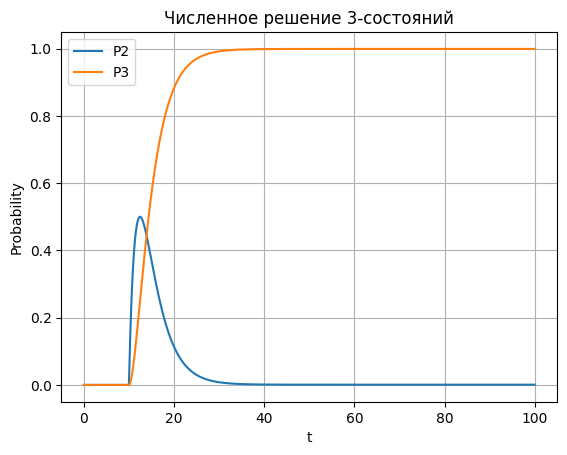

In [4]:
V_0 = -180
V_1 = 0

    
# Заданные параметры
a_alpha = 0.0628
b_alpha = -2.163
a_beta = 0.0872
b_beta = 9.16

par_a = [a_alpha, b_alpha]
par_b = [a_beta, b_beta]

# Функция напряжения
V_func = lambda t: -40  # постоянное

# Начальные условия
y0 = [0.0, 0.0]

# Решение ОДУ
sol = solve_ivp(
    fun=lambda t, y: kolm_mod.state_x3_depend_ab_rph(t, y, kolm_mod.V_volt_clamp, alpha_func=alpha_full, beta_func=beta_full,
                                            p_alpha=par_a, p_beta=par_b, V_0=V_0, V_1=V_1, t_0=10),
    t_span=(0, 100),
    y0=y0,
    t_eval=np.linspace(0, 100, 1000)
)

# График
plt.plot(sol.t, sol.y[0], label='P2')
plt.plot(sol.t, sol.y[1], label='P3')
plt.xlabel("t")
plt.ylabel("Probability")
plt.legend()
plt.grid(True)
plt.title("Численное решение 3-состояний")
plt.show()

In [5]:
# -------------------------------------------------------------------
# 1.  Volt-Clamp
V_0 = -180
V_1 = 0
# -------------------------------------------------------------------
# 2.  Начальные (очень широкие) пределы
# Заданные параметры
a_alpha = 0.0628
b_alpha = -2.163
a_beta = 0.0872
b_beta = 9.16        

# Расширенные пределы
bounds = np.array([
    [-2,  2],  # a_alpha
    [-30.,  30.],   # b_alpha
    [-2,  2],  # a_beta
    [-50.,  50.]    # b_beta
])
# -------------------------------------------------------------------
# 3.  Проверка решения
# -------------------------------------------------------------------
def is_valid(param_vec):
    y_0=[0., 0.]
    a_a, b_a, a_b, b_b = param_vec
    try:
        # Функция проверки на собственные числа
        if -a_a - a_b >= 0:  # Простейшая проверка по условию -alpha - beta < 0
            return False
        sol = solve_ivp(lambda t, y:
                        kolm_mod.state_x3_depend_ab_rph(
                        t, y, kolm_mod.V_volt_clamp,
                        alpha_func=kolm_mod.alpha_full,
                        beta_func=kolm_mod.beta_full,
                        p_alpha=[a_a, b_a],
                        p_beta=[a_b, b_b],
                        V_0=V_0, V_1=V_1, t_0=10),
                        (0, 100), y_0,
                        t_eval=np.linspace(0, 100, 400),
                        rtol=1e-5, atol=1e-8)
        return sol.success and np.isfinite(sol.y).all()
    except Exception as e:
        print(f"Error: {e}")
        return False

# -------------------------------------------------------------------
# 4.  Итеративное сужение границ
# -------------------------------------------------------------------
n_iter   = 3          # сколько раз уточняем
n_points = 8000       # сколько точек в каждой итерации
shrink   = 0.50       # насколько «съедаем» пустой край (10 %)

for k in range(n_iter):
    # 4.1 LHS-семплирование внутри текущих bounds
    problem = {
    "num_vars": 4,
    "names":    ["a_alpha", "b_alpha", "a_beta", "b_beta"],
    "bounds":   bounds.tolist()          # ←  БЕЗ .T
    }
    sample = latin.sample(problem, n_points)

    # 4.2 Параллельно проверяем
    valid_mask = Parallel(n_jobs=-1, verbose=0)(
        delayed(is_valid)(p) for p in sample)
    
    # Убедимся, что sample и valid_mask соответствуют
    valid_pts = sample[np.array(valid_mask)]

    if valid_pts.size == 0:
        raise RuntimeError(f"На итерации {k+1} не найдено ни одной валидной точки. Попробуйте расширить диапазоны.")
    
    # 4.3 Новые границы = min/max по валидным точкам
    new_bounds = np.column_stack((valid_pts.min(axis=0),
                                  valid_pts.max(axis=0)))

    # 4.4 «Съедаем» пустое пространство
    span = new_bounds[:,1] - new_bounds[:,0]
    bounds = np.column_stack((new_bounds[:,0] - shrink*span,
                              new_bounds[:,1] + shrink*span))
# -------------------------------------------------------------------
# 5.  Результат
# -------------------------------------------------------------------
pars = ["a_alpha","b_alpha","a_beta","b_beta"]
for name,(lo,hi) in zip(pars,bounds):
    print(f"{name:7s}: [{lo: .5f} {hi: .5f}]")


/Users/anko/PycharmProjects/NVK_biophis_model/___kolmogorov_models.py:147: RuntimeWarning: overflow encountered in scalar multiply
  dP2dt = 2 * alpha * (1 - P2 - P3) + 2 * beta * P3 + (-alpha - beta) * P2
/Users/anko/PycharmProjects/NVK_biophis_model/___kolmogorov_models.py:148: RuntimeWarning: overflow encountered in scalar multiply
  dP3dt = alpha * P2 - 2 * beta * P3
/Users/anko/PycharmProjects/NVK_biophis_model/venv/lib/python3.11/site-packages/scipy/integrate/_ivp/rk.py:66: RuntimeWarning: invalid value encountered in dot
  y_new = y + h * np.dot(K[:-1].T, B)
/Users/anko/PycharmProjects/NVK_biophis_model/venv/lib/python3.11/site-packages/scipy/integrate/_ivp/rk.py:109: RuntimeWarning: invalid value encountered in divide
  return norm(self._estimate_error(K, h) / scale)
/Users/anko/PycharmProjects/NVK_biophis_model/___kolmogorov_models.py:147: RuntimeWarning: overflow encountered in scalar multiply
  dP2dt = 2 * alpha * (1 - P2 - P3) + 2 * beta * P3 + (-alpha - beta) * P2
/Users/a

KeyboardInterrupt: 

In [ ]:
# -------------------------------------------------------------------
# 5.  Результат
# -------------------------------------------------------------------
pars = ["a_alpha","b_alpha","a_beta","b_beta"]
for name,(lo,hi) in zip(pars,bounds):
    print(f"{name:7s}: [{lo: .5f} {hi: .5f}]")

In [ ]:
# 4-state

In [ ]:
pars

In [ ]:
# Тестовая функция вероятности открытия
def bolt_Popen(V, V12=-80, s=6):
    return 1 / (1 + np.exp((V - V12) / s))

def tau(V):
    return 4  # можно заменить на любую функцию

In [ ]:
# Функции переходов
def alpha_test(V, bolt_Popen, V12, s, tau):
    P = (bolt_Popen(V, V12=V12, s=s))**(1/3)
    return P / tau(V)

def beta_test(V, bolt_Popen, V12, s, tau):
    P = (bolt_Popen(V, V12=V12, s=s))**(1/3)
    return (1 - P) / tau(V)

    # Функции переходов

def alpha_full(V, a_alpha, b_alpha):
    u = a_alpha * V + b_alpha
    # Чтобы избежать деления на 0 при u → 0
    with np.errstate(divide='ignore', invalid='ignore'):
        result = np.where(np.abs(u) < 1e-8, 1.0, u / (1 - np.exp(-u)))
    return result

def beta_full(V, a_beta, b_beta):
    u = a_beta * V + b_beta
    return np.exp(-u)

In [ ]:
    # Функции интенсивностей для активацинных ворот -- растущая // из закрытого в открытое
def alpha_full(V, p_alpha):
    a_alpha, b_alpha = p_alpha[0], p_alpha[1]
    u = a_alpha * V + b_alpha
    # Чтобы избежать деления на 0 при u → 0
    with np.errstate(divide='ignore', invalid='ignore'):
        result = np.where(np.abs(u) < 1e-8, 1.0, u / (1 - np.exp(-u)))
    return result
    
# для активацинных ворот -- убывающая // из открытого в закрытое
def beta_full(V, p_beta): # из открытого в закрытое
    a_alpha, b_alpha = p_beta[0], p_beta[1]
    u = a_beta * V + b_beta
    return np.exp(-u)

def state_x4_depend_ab_stat_sol(V,  alpha_func, beta_func, p_alpha, p_beta):
    alpha = alpha_func(V, p_alpha)
    beta = beta_func(V, p_beta)

    denom = alpha**3 + 3*alpha**2*beta + 3*alpha*beta**2 + beta**3

    P2_eq = 3 * alpha * beta**2 / denom
    P3_eq = 3 * alpha**2 * beta / denom
    P4_eq = alpha**3 / denom

    return {
        'P2_eq': P2_eq,
        'P3_eq': P3_eq,
        'P4_eq': P4_eq
    }

def state_x4_depend_ab_rph(t, y, V_func, alpha_func=alpha_full, beta_func=beta_full,
                           p_alpha=[0,0], p_beta=[0,0], V_0=-170, V_1=-10, t_0=10):
    """
    Правая часть системы ОДУ для модели с четырьмя состояниями ворот.
    
    Параметры:
    ----------
    t : float
        Время
    y : array-like
        Вектор состояния [P2, P3, P4]
    V_func : callable
        Функция напряжения V(t)
    a_alpha, b_alpha : float
        Параметры функции α(V)
    a_beta, b_beta : float
        Параметры функции β(V)
        
    Возвращает:
    -----------
    dydt : list[float]
        Производные [dP2/dt, dP3/dt, dP4/dt]
    """
    P2, P3, P4 = y
    V = V_func(t, V_0, V_1, t_0=10)

    alpha = alpha_func(V, p_alpha)
    beta = beta_func(V, p_beta)

    dP2dt = 3 * alpha * (1 - P2 - P3 - P4) + 2 * beta * P3 + (-2 * alpha - beta) * P2
    dP3dt = 2 * alpha * P2 + 3 * beta * P4 + (-alpha - 2 * beta) * P3
    dP4dt = alpha * P3 - 3 * beta * P4

    return [dP2dt, dP3dt, dP4dt]


In [ ]:
V_0 = -180
V_1 = -70
def V_volt_clamp(t, V_0, V_1, t_0=10): 
    return V_0 if t < t_0 else V_1

In [ ]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Заданные параметры
a_alpha = 0.0628
b_alpha = -2.163
a_beta = 0.0872
b_beta = 9.16

par_a = [a_alpha, b_alpha]
par_b = [a_beta, b_beta]

# Функция напряжения
V_func = lambda t: -40  # постоянное

# Начальные условия
y0 = [0.0, 0.0, 0.0]

# Решение ОДУ
sol = solve_ivp(
    fun=lambda t, y: state_x4_depend_ab_rph(t, y, V_volt_clamp, alpha_func=alpha_full, beta_func=beta_full,
                                            p_alpha=par_a, p_beta=par_b, V_0=V_0, V_1=V_1, t_0=10),
    t_span=(0, 100),
    y0=y0,
    t_eval=np.linspace(0, 100, 1000)
)

# График
plt.plot(sol.t, sol.y[0], label='P2')
plt.plot(sol.t, sol.y[1], label='P3')
plt.plot(sol.t, sol.y[2], label='P4')
plt.xlabel("t")
plt.ylabel("Probability")
plt.legend()
plt.grid(True)
plt.title("Численное решение 4-состояний")
plt.show()


In [ ]:
import nevergrad as ng

# ----------------------------------------------------------------------
# 2. Функция-цель «0 — если решение существует, иначе 10⁶»
# ----------------------------------------------------------------------
def objective(x):
    # x = [a_alpha, b_alpha, a_beta, b_beta, V_0, V_1]
    a_alpha, b_alpha, a_beta, b_beta, V_0, V_1 = x
    p_alpha = [a_alpha, b_alpha]
    p_beta  = [a_beta, b_beta]
    try:
        sol = solve_ivp(
            fun=lambda t, y: state_x4_depend_ab_rph(
                t, y, V_volt_clamp,
                alpha_func=alpha_full,
                beta_func=beta_full,
                p_alpha=p_alpha,
                p_beta=p_beta,
                V_0=V_0,
                V_1=V_1                # ← КЛЮЧ: передаём прямо сюда!
            ),
            t_span=(0, 100),
            y0=[0.0, 0.0, 0.0],
            t_eval=np.linspace(0, 100, 400),
            rtol=1e-5,
            atol=1e-8
        )
        return 0.0 if is_solution_valid(sol) else 1e6
    except Exception:
        return 1e6

In [ ]:
# ----------------------------------------------------------------------
# 3. Параметризация Nevergrad
# ----------------------------------------------------------------------
bounds_min = [-0.01,  -20, -0.01,  -20, -180, -180]   # a_α, b_α, a_β, b_β, V_0, V_1
bounds_max = [0.20,   20, 0.20,   20,   20,   20]

parametrization = ng.p.Array(shape=(6,)).set_bounds(bounds_min, bounds_max)

optimizer = ng.optimizers.NGOpt(
    parametrization=parametrization,
    budget=2000                # ← сколько «шагов» (решений ОДУ) вы готовы посчитать
)

recommendation = optimizer.minimize(objective)



In [ ]:
print("Найдено допустимое решение:")
print(f" a_alpha = {recommendation.value[0]:.5f}")
print(f" b_alpha = {recommendation.value[1]:.5f}")
print(f" a_beta  = {recommendation.value[2]:.5f}")
print(f" b_beta  = {recommendation.value[3]:.5f}")
print(f" V_0     = {recommendation.value[4]:.2f} mV")
print(f" V_1     = {recommendation.value[5]:.2f} mV")

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from itertools import repeat
from SALib.sample import latin       # pip install SALib
from joblib import Parallel, delayed # pip install joblib

# -------------------------------------------------------------------
# 1.  Volt-Clamp
# -------------------------------------------------------------------
V0, V1 = -170.0, -50.0          
# -------------------------------------------------------------------
# 2.  Начальные (очень широкие) пределы
# -------------------------------------------------------------------
bounds = np.array([
    [-1,  1],  # a_alpha
    [-30.,  30.],   # b_alpha
    [-1,  1],  # a_beta
    [-30.,  30.]    # b_beta
])
# -------------------------------------------------------------------
# 3.  Проверка решения
# -------------------------------------------------------------------
def is_valid(param_vec):
    a_a, b_a, a_b, b_b = param_vec
    try:
        sol = solve_ivp(lambda t, y:
                            state_x4_depend_ab_rph(
                                t, y, V_volt_clamp,
                                alpha_func=alpha_full,
                                beta_func=beta_full,
                                p_alpha=[a_a, b_a],
                                p_beta=[a_b, b_b],
                                V_0=V0, V_1=V1),
                        (0, 100), [0., 0., 0.],
                        t_eval=np.linspace(0, 100, 400),
                        rtol=1e-5, atol=1e-8)
        return sol.success and np.isfinite(sol.y).all()
    except Exception:
        return False

# -------------------------------------------------------------------
# 4.  Итеративное сужение границ
# -------------------------------------------------------------------
n_iter   = 3          # сколько раз уточняем
n_points = 8000       # сколько точек в каждой итерации
shrink   = 0.10       # насколько «съедаем» пустой край (10 %)

for k in range(n_iter):
    # 4.1 LHS-семплирование внутри текущих bounds
    problem = {
    "num_vars": 4,
    "names":    ["a_alpha", "b_alpha", "a_beta", "b_beta"],
    "bounds":   bounds.tolist()          # ←  БЕЗ .T
    }
    sample = latin.sample(problem, n_points)

    # 4.2 Параллельно проверяем
    valid_mask = Parallel(n_jobs=-1, verbose=0)(
        delayed(is_valid)(p) for p in sample)
    valid_pts = sample[np.array(valid_mask)]

    if valid_pts.size == 0:
        raise RuntimeError("На итерации %d не найдено ни одной валидной точки" % (k+1))

    # 4.3 Новые границы = min/max по валидным точкам
    new_bounds = np.column_stack((valid_pts.min(axis=0),
                                  valid_pts.max(axis=0)))

    # 4.4 «Съедаем» пустое пространство
    span = new_bounds[:,1] - new_bounds[:,0]
    bounds = np.column_stack((new_bounds[:,0] - shrink*span,
                              new_bounds[:,1] + shrink*span))

In [ ]:
# -------------------------------------------------------------------
# 5.  Результат
# -------------------------------------------------------------------
pars = ["a_alpha","b_alpha","a_beta","b_beta"]
for name,(lo,hi) in zip(pars,bounds):
    print(f"{name:7s}: [{lo: .5f} {hi: .5f}]")

#### Выводы
Для разных Volt Clamp имеем следующие допустимыле области значений:
1) V: -180.0 -> -40.0: \
a_alpha: [-1.72736  1.72745] \
b_alpha: [-51.82433  51.82322] \
a_beta : [-1.72722  1.72745] \
b_beta : [-51.81788  51.82206] \
комментарий: область симметрична
2) при обратном переходе V: -40.0 -> -180.0: \
   a_alpha: [-1.72722  1.72736] \
b_alpha: [-51.81554  51.81188] \
a_beta : [-1.72710  1.72724] \
b_beta : [-51.82585  51.82027] \
значения близки. возможно погрешность счета
3) V: -20.0 -> -180.0: результат не меняется